In [188]:
import os
import csv
import numpy as np
import utils
import hrr_utils
import time
import random
import scipy
import sklearn

from __future__ import division
from pylab import *
from scipy import spatial
from scipy.spatial import distance
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})


cwd = os.getcwd()


alph = 'abcdefghijklmnopqrstuvwxyz#.'
N=6000
D = len(alph)
dic1 = letter_vecs1 = 2 * (np.random.randn(D, N) < 0) - 1
dic2 = letter_vecs2 = 2 * (np.random.randn(D, N) < 0) - 1


def read_verbs(url):
    keys = ['low', 'medium', 'high']
    verbs = {key: [] for key in keys}
    
    with open(url, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        curr_verbs = []
        i = 0
        for row in reader:
            if row[0] in keys:
                curr_verbs = verbs[row[0]]
            else:
                curr_verbs.append([row[0], row[1]])
            i+=1
    return verbs

def ngram_encode(ngram_str, letter_vecs):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs):
    vec = ngram_encode(ngram_str, letter_vecs)
    
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def genX(verbs):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))
    
    for m in range(len(verbs)):
        pair = verbs[m]
        PRES1[m] = ngram_encode_cl(pair[1], dic1)
        PRES2[m] = ngram_encode_cl(pair[1], dic2)
        PAST1[m] = ngram_encode_cl(pair[0], dic1)
        PAST2[m] = ngram_encode_cl(pair[0], dic2)
#         print(pair[0], np.sum(PRES1[m]), pair[1], np.sum(PRES2[m]))
        
    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2

def gen_verb_set(verbs, freq_sizes):
    keys = ['high', 'medium', 'low']
    verb_set_keys = ['dif', 'pres1', 'pres2', 'past1', 'past2']
    size = sum([freq_sizes[freq] for freq in keys])    
    verb_set = {key: np.zeros((size, N)) for key in verb_set_keys}
    i = 0
    verbs_to_encode = []
    for freq in keys:
        size = freq_sizes[freq]
        indices = list(np.random.choice(len(verbs[freq]), size, replace=False))
        verbs_to_encode += [verbs[freq][index] for index in indices]
        
    verb_set['dif'], verb_set['pres1'], verb_set['pres2'], verb_set['past1'], verb_set['past2'] = genX(verbs_to_encode)

    return verb_set, verbs_to_encode

def train_diff(tv, past2, present1, present2, sim):
    tv += np.multiply(present1, past2-present2)
    return tv

def reg_train_diff(tv, past2, present1, present2, sim):
    pred = np.multiply(tv, present1) + present2
    tv += ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)
    return tv

def closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present), Past)

def cap_closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present,rcond=5e-2), Past)

def sim(x, y, dist=None):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def compare(pred, past2):
    acc = 0
    indices = []
    for i in range(pred.shape[0]):
        sims = sim(past2, pred[i])
        predi = np.argmax(sims)
        acc += i == predi
        indices.append((i, predi))
    return acc/float(past2.shape[0]), indices
        
def round_to_tick(number):
    """Round a number to the closest half integer."""
    return round(number * 2) / 2

def graph_onetype(x, y, ystd, accuracy, title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   
    plt.figure(1)
    plt.subplot(211)

    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)

    start = round_to_tick(min(y) - max(ystd))
    end = round_to_tick(max(y) + max(ystd))
    
    ystd = np.clip(ystd, max(-8, start-.5), min(8, end+.5))
    plt.plot(x, y, c='b', lw=2, label='Train')
    plt.fill_between(x, y-ystd, y+ystd, facecolor='b', alpha=0.1)
    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
#     plt.title(title,fontsize=16)
    plt.tight_layout()
    
    plt.subplot(212)
    plt.plot(x, accuracy)
    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)


def graph(x, y1, y2, y1std, y2std, accuracy, irreg_accuracy, title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   
    plt.figure(1)
    plt.subplot(211)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    
    start = round_to_tick(min(min(y1), min(y2)) - max(max(y1std),max(y2std)))
    end = round_to_tick(max(max(y1), max(y2)) + max(max(y1std),max(y2std)))
    
    y1std = np.clip(y1std, max(-8, start-.5), min(8, end+.5))
    y2std = np.clip(y2std, max(-8, start-.5), min(8, end+.5))
    

    plt.plot(x, y1, c='b', lw=2, label='Regular')
    plt.plot(x, y2, c='g', lw=2, label='Irregular')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)
    
#     plt.fill_between(x, y2-y2std, y2+y2std, color='none', alpha=0.3, hatch="////", edgecolor="g")


    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
#     plt.title(title,fontsize=16)

    plt.tight_layout()

    plt.subplot(212)
    plt.plot(x, accuracy, c='b', label='Regular')
    plt.plot(x, irreg_accuracy, c='g', label='Irregular')
    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.legend(loc=legend,fontsize=12)

In [189]:
# todo: create training and test set of verb pairs for resonance attractor
irreg_verbs1 = read_verbs('data/cleaned/R&M_irregular.csv')
irreg_verbs2 = read_verbs('data/cleaned/Brown_irregular_std=1.csv')
reg_verbs = read_verbs('data/cleaned/Brown_regular_std=0.25.csv')


In [190]:

irreg_verbs = irreg_verbs1

for freq, tenses in irreg_verbs2.items():
    irreg_verbs[freq] += tenses
    
for k, v in irreg_verbs.items():
    print (k, len(v))
    
comb_verbs = reg_verbs
for freq, tenses in irreg_verbs.items():
    comb_verbs[freq] += tenses

('high', 8)
('medium', 217)
('low', 49)


In [191]:
for k, v in irreg_verbs.items():
    print (k, len(v))
    
for k, v in reg_verbs.items():
    print (k, len(v))

('high', 8)
('medium', 217)
('low', 49)
('high', 260)
('medium', 1590)
('low', 871)


In [192]:
"""
10 high freq
410 med freq
86 low freq

irregular
8 high freq
76 med freq
14 low freq

regular
2 high freq
334 med freq
72 low freq 
"""
irreg_freqs = {'high': 8, 'medium': 76, 'low': 14}
reg_freqs = {'high': 2, 'medium': 334, 'low': 72}
comb_freqs = {'high': 10, 'medium': 410, 'low': 86}
irreg_vecs, irreg_verbs = gen_verb_set(irreg_verbs, irreg_freqs)
reg_vecs, reg_verbs = gen_verb_set(reg_verbs, reg_freqs)
comb_vecs, comb_verbs = gen_verb_set(comb_verbs, comb_freqs)

In [193]:
# todo: create input vectors (online difference algo and regression) for resonance attractor
def diff_trigram_dict_onetype(past2, pres1, pres2, train_func=train_diff, similarity=sim):
    psi = np.zeros(N)
    psi = train_func(psi, past2[0], pres1[0], pres2[0], similarity)
    
    x = np.arange(1, pres1.shape[0]+1, 1)
    y = np.zeros(pres1.shape[0])
    ystd = np.zeros(pres1.shape[0])
    accuracy = np.zeros(pres1.shape[0])
    for k in range(1,past2.shape[0]):
        pred = np.multiply(psi, pres1[:k])/float(N) + pres2[:k]
        sim1 = sim(pred, past2[:k])
        
        y[k] = sim1.mean()
        ystd[k] = np.nanstd(sim1, axis=0)
        accuracy[k], indices = compare(pred, past2[:k])

        psi = train_func(psi, past2[k], pres1[k], pres2[k], similarity)
    return psi, x,y,ystd,accuracy



figures/unregularized_trigam_dict-N=6000-W=98-171026


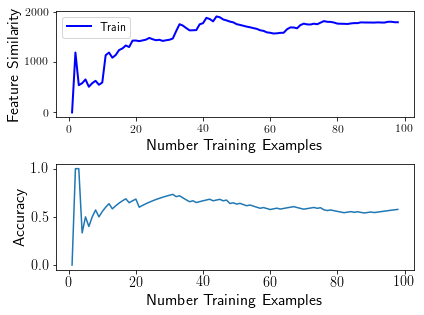

In [194]:
diff_psi_irreg,x,y,ystd,accuracy = diff_trigram_dict_onetype(irreg_vecs['past2'], irreg_vecs['past1'], irreg_vecs['pres2'])
title = 'unregularized'
legend = 'upper left'
graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/unregularized_trigam_dict-N=6000-W=408-171026


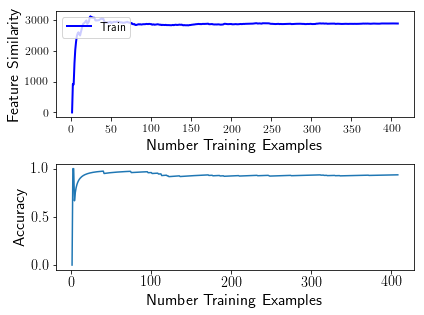

In [195]:
diff_psi_reg, x,y,ystd,accuracy = diff_trigram_dict_onetype(reg_vecs['past2'], reg_vecs['past1'], reg_vecs['pres2'])
title = 'unregularized'
legend = 'upper left'
graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/regularized_trigam_dict-N=6000-W=98-171026


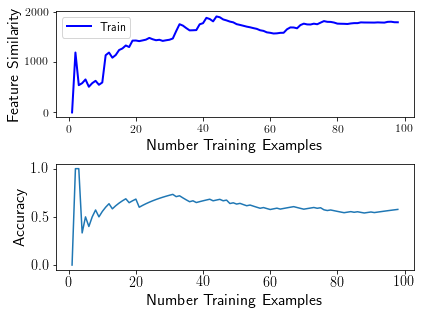

In [196]:
regularized_diff_psi_irreg,x,y,ystd,accuracy = diff_trigram_dict_onetype(irreg_vecs['past2'], irreg_vecs['past1'], irreg_vecs['pres2'], reg_train_diff)
title = 'regularized'
legend = 'upper left'
graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/regularized_trigam_dict-N=6000-W=408-171026


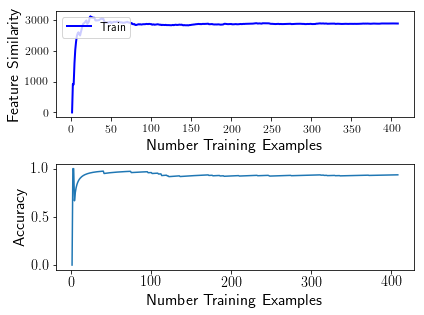

In [197]:
regularized_diff_psi_reg, x,y,ystd,accuracy = diff_trigram_dict_onetype(reg_vecs['past2'], reg_vecs['past1'], reg_vecs['pres2'], reg_train_diff)
title = 'regularized'
legend = 'upper left'
graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [198]:
def diff_trigram_dict(comb_past2, comb_pres1, comb_pres2, irreg_past2, irreg_pres1, irreg_pres2, train_func=train_diff, similarity=sim):
    psi = np.zeros(N)
    psi = train_func(psi, comb_past2[0], comb_pres1[0], comb_pres2[0], similarity)

    x = np.arange(1, comb_pres1.shape[0]+1, 1)
    y1 = np.zeros(comb_pres1.shape[0])
    y2 = np.zeros(comb_pres1.shape[0])
    y1std = np.zeros(comb_pres1.shape[0])
    y2std = np.zeros(comb_pres1.shape[0])

    accuracy = np.zeros(comb_pres1.shape[0])
    irreg_accuracy = np.zeros(comb_pres1.shape[0])

    for k in range(1,comb_past2.shape[0]):
        pred = np.multiply(psi, comb_pres1[:k]) + comb_pres2[:k]
        irreg_pred = np.multiply(psi, irreg_pres1) + irreg_pres2

        sim1 = sim(pred, comb_past2[:k])
        sim2 = sim(irreg_pred, irreg_past2)

        y1[k] = sim1.mean()
        y2[k] = sim2.mean()
        y1std[k] = np.nanstd(sim1, axis=0)
        y2std[k] = np.nanstd(sim2, axis=0)
        accuracy[k], indices = compare(pred, comb_past2[:k])
        irreg_accuracy[k], irreg_indices = compare(irreg_pred, irreg_past2[:k])

        psi = train_func(psi, comb_past2[k], comb_pres1[k], comb_pres2[k], similarity)
    return psi,x,y1,y2,y1std,y2std, accuracy, irreg_accuracy


figures/unregularized_trigam_dict-N=6000-W=408-171026


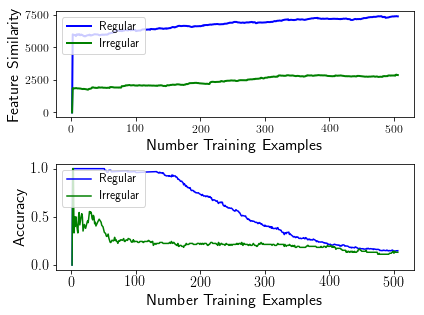

In [199]:
diff_psi,x,y1,y2,y1std,y2std,accuracy, irreg_accuracy = diff_trigram_dict(comb_vecs['past2'], 
                                                                 comb_vecs['pres1'],
                                                                 comb_vecs['pres2'],
                                                                 irreg_vecs['past2'],
                                                                 irreg_vecs['pres1'],
                                                                 irreg_vecs['pres2'])
title = 'unregularized'
legend = 'upper left'
graph(x,y1,y2,y1std,y2std,accuracy,irreg_accuracy, title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/regularized_trigam_dict-N=6000-W=408-171026


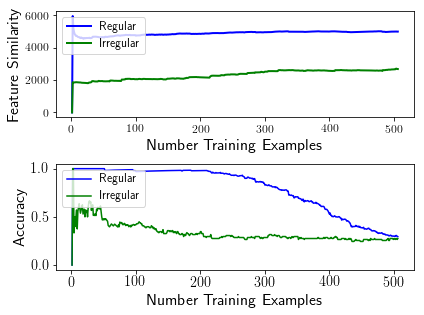

In [200]:
regularized_diff_psi, x,y1,y2,y1std,y2std,accuracy, irreg_accuracy = diff_trigram_dict(comb_vecs['past2'], 
                                                                 comb_vecs['pres1'],
                                                                 comb_vecs['pres2'],
                                                                 irreg_vecs['past2'],
                                                                 irreg_vecs['pres1'],
                                                                 irreg_vecs['pres2'],
                                                                 reg_train_diff
                                                                )
title = 'regularized'
legend = 'upper left'
graph(x,y1,y2,y1std,y2std,accuracy,irreg_accuracy, title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [201]:
# def closed_train(Past, Present):
#     return np.dot(np.linalg.pinv(Present), Past)

# def cap_closed_train(Past, Present):
#     return np.dot(np.linalg.pinv(Present,rcond=5e-2), Past)

def diff_trigram_regress_onetype(past1, pres1, past2, pres2, train_func=closed_train):
    x = np.arange(1, pres1.shape[0]+1, 1)
    y = np.zeros(pres1.shape[0])
    ystd = np.zeros(pres1.shape[0])
    accuracy = np.zeros(pres1.shape[0])

    for i in range(1, x.shape[0]):
        k = x[i]
        W = train_func(past2[:k]-pres2[:k], pres1[:k])
        pred = pres1[:k].dot(W) + pres2[:k]

        sim1 = sim(pred, past2[:k])

        y[i] = sim1.mean()/N
        ystd[i] = np.nanstd(sim1, axis=0)/N
        accuracy[i], indices = compare(pred, past2[:k])
        
    W = train_func(past2-pres2, pres1)
    return W, x,y,ystd,accuracy


def diff_trigram_regress(comb_past1,
                         comb_pres1,
                         comb_past2,
                         comb_pres2,
                         irreg_past2,
                         irreg_pres2,
                         irreg_pres1,
                         train_func=closed_train):
    x = np.arange(1, comb_past1.shape[0], 10)
    y1 = np.zeros(x.shape[0])
    y2 = np.zeros(x.shape[0])
    y1std = np.zeros(x.shape[0])
    y2std = np.zeros(x.shape[0])
    accuracy = np.zeros(x.shape[0])
    irreg_accuracy = np.zeros(x.shape[0])
    for i in range(1, x.shape[0]):#trainpres1.shape[0]):
        k = x[i]
        W = closed_train(comb_past2[:k]-comb_pres2[:k], comb_pres1[:k])
        comb_pred = comb_pres1[:k].dot(W) + comb_pres2[:k]
        irreg_pred = irreg_pres1.dot(W) + irreg_pres2

        sim1 = sim(comb_pred, comb_past2[:k])
        sim2 = sim(irreg_pred, irreg_past2)

        y1[i] = sim1.mean()/N
        y1std[i] = np.nanstd(sim1, axis=0)/N
        y2[i] = sim2.mean()/N
        y2std[i] = np.nanstd(sim2, axis=0)/N

        accuracy[i], indices = compare(comb_pred, comb_past2[:k])
        irreg_accuracy[i], irreg_indices = compare(irreg_pred, irreg_past2)

    W = closed_train(comb_past2-comb_pres2, comb_pres1)
    return W,x,y1,y2,y1std,y2std, accuracy, irreg_accuracy


In [202]:
W_reg,x,y,ystd,accuracy = diff_trigram_regress_onetype(reg_vecs['past1'], reg_vecs['pres1'], reg_vecs['past2'], reg_vecs['pres2'])
title = 'regression regular'
legend = 'upper left'
graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

KeyboardInterrupt: 

In [ ]:
W_irreg,x,y,ystd,accuracy = diff_trigram_regress_onetype(irreg_vecs['past1'], irreg_vecs['pres1'], irreg_vecs['past2'], irreg_vecs['pres2'])
title = 'regression irregular'
legend = 'upper left'
graph_onetype(x,y,ystd,accuracy,title=title,legend=legend)
fname =  ('figures/'+title+'_trigam_dict-N=' + str(N) + '-W=' + str(y.shape[0]) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [ ]:
W_comb,x,y1,y2,y1std,y2std, accuracy, irreg_accuracy = diff_trigram_regress(comb_vecs['past1'],
                                                                       comb_vecs['pres1'],
                                                                       comb_vecs['past2'],
                                                                       comb_vecs['pres2'],
                                                                       irreg_vecs['past2'],
                                                                       irreg_vecs['pres2'],
                                                                       irreg_vecs['pres1']
                                                                      )

graph(x,y1,y2,y1std,y2std,accuracy, irreg_accuracy, title="diff-unregularized")

fname =  ('figures/regression-diff_unregularized_closedform_trigam-N=' + str(N)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [111]:
print (x.shape, y1.shape, y2.shape, y1std.shape, y2std.shape, accuracy.shape, irreg_accuracy.shape)

((51,), (51,), (51,), (51,), (51,), (51,), (51,))


In [203]:
# todo: output reconstructions of verb in proper tense for resonance attractor
inputs = [ 
    diff_psi_irreg,
    diff_psi_reg,
    diff_psi,
    regularized_diff_psi_irreg,
    regularized_diff_psi_reg,
    regularized_diff_psi,
    W_reg,
    W_irreg,
    W_comb
]
    


In [204]:
# PAST PRESENT TENSE DIFFERENCE
def create_bound_vecs(verbs, vecs, N):
    present_strs = [pair[0] for pair in verbs]
    past_strs = [pair[1] for pair in verbs]
    bound_vec = np.zeros(N)
    regularized_bound_vec = np.zeros(N)
    for i in range(len(past_strs)):
        past1 = vecs['past1'][i]
        pres1 = vecs['pres1'][i]
        past2 = vecs['past2'][i]
        pres2 = vecs['pres2'][i]
        bound_diff = pres1 * (past2 - pres2)
        pred = regularized_bound_vec*pres1 + pres2

        regularized_bound_vec += ((N-sim(pred, past1))/float(N)) * bound_diff
        bound_vec += bound_diff
            
    return bound_vec, regularized_bound_vec, present_strs, past_strs

irreg_boundvec, regularized_irreg_boundvec, irreg_present_strs, irreg_past_strs = create_bound_vecs(irreg_verbs, irreg_vecs, N)
reg_boundvec, regularized_reg_boundvec, reg_present_strs, reg_past_strs = create_bound_vecs(reg_verbs, reg_vecs, N)
comb_boundvec, regularized_comb_boundvec, comb_present_strs, comb_past_strs = create_bound_vecs(comb_verbs, comb_vecs, N)

n_steps = 100

In [205]:
def state_setup(state_length, letter_vecs, N, D, n_steps):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
    
    return states, coef_hists

def iterate(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, n_steps):
    for i in range(n_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            ## Need to make sure that the largest absolute value is always positive,
            ## because the unbinding inference can flip 2 and be the same

            mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            states[j] *= np.sign(coef_hists[j-1][i, mxidx])
            
            if j == 1:
                ljd = (np.roll(bound_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  bound_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(bound_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(bound_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      bound_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(bound_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(bound_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2
#             print ('iterate', (np.dot(ljd, letter_vecs.T)/N).shape, letter_vecs.T.shape)
            states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T)/N)
            states[j] = states[j]/norm(states[j])

    return states, coef_hists

In [206]:
def predict(bound_vec, pres_vec1, pres_vec2, word_length, dic1, N, D, nsteps, linreg=False):
    if linreg:
        pred_vec = pres_vec1.dot(bound_vec) + pres_vec2
    else:
        pred_vec = pres_vec1 * bound_vec + pres_vec2

    states, coef_hists = state_setup(word_length+2, dic1, N, D, n_steps)
    print ('state_setup', len(states), states[0].shape, coef_hists[0].shape)
    print ('pred_vec', pred_vec.shape)
    states, coef_hists = iterate(pred_vec, states, coef_hists, word_length+2, dic1, N, D, n_steps)

#     figure(figsize=(10,3))
#     cols = get_cmap('copper', min(50,n_steps))
#     for i in range(min(50,n_steps)):
#         subplot(131)
#         plot(coef_hists[0][i,:], lw=3, c=cols(i))
#         subplot(132)
#         plot(coef_hists[1][i,:], lw=3, c=cols(i))
#         subplot(133)
#         plot(coef_hists[2][i,:], lw=3, c=cols(i))

    pred = ''
    for i in range(len(coef_hists)):
        pred += alph[np.argmax(np.abs(coef_hists[i][-1,:]))]

    return pred

In [208]:
# predict a word in bound_vec
# unregularized bind

bound_vecs = [ 
    diff_psi_irreg,
    diff_psi_reg,
    diff_psi,
    regularized_diff_psi_irreg,
    regularized_diff_psi_reg,
    regularized_diff_psi
]
bound_matrices = [
    W_reg,
    W_irreg,
    W_comb
]
nsteps = 50
# for bound_vec in bound_vecs:
# these two bound_vecs are essentially the same. May have a problem with too many verbs
bound_vec = bound_vecs[0]
bound_vec = irreg_boundvec
for i in range(len(irreg_past_strs)):
    pred = predict(bound_vec, irreg_vecs['pres1'][i], irreg_vecs['pres2'][i], len(irreg_past_strs[i]), dic1, N, D, nsteps)
    print (irreg_past_strs[i], pred)


('state_setup', 5, (6000,), (100, 28))
('pred_vec', (6000,))
('had', 'rhp')
('state_setup', 6, (6000,), (100, 28))
('pred_vec', (6000,))
('took', 'uhqp')
('state_setup', 6, (6000,), (100, 28))
('pred_vec', (6000,))
('gave', 'kari')
('state_setup', 6, (6000,), (100, 28))
('pred_vec', (6000,))
('came', 'jwiz')
('state_setup', 5, (6000,), (100, 28))
('pred_vec', (6000,))
('got', 'lkq')
('state_setup', 6, (6000,), (100, 28))
('pred_vec', (6000,))
('made', 'stab')
('state_setup', 6, (6000,), (100, 28))
('pred_vec', (6000,))
('felt', 'welu')
('state_setup', 6, (6000,), (100, 28))
('pred_vec', (6000,))
('went', 'ookb')
('state_setup', 6, (6000,), (100, 28))
('pred_vec', (6000,))
('wept', 'xqhq')
('state_setup', 5, (6000,), (100, 28))
('pred_vec', (6000,))
('set', 'tnn')
('state_setup', 7, (6000,), (100, 28))
('pred_vec', (6000,))
('wrung', 'bahqg')
('state_setup', 6, (6000,), (100, 28))
('pred_vec', (6000,))
('told', 'e#vx')
('state_setup', 8, (6000,), (100, 28))
('pred_vec', (6000,))
('becam

In [ ]:
# predict a word NOT in bound_vec